In [693]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import datetime
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn import linear_model
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import time
import cPickle as pickle

import qgrid

%load_ext autoreload
%autoreload 2

from functions import *
from plots import *

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8  # plotsize 

#qgrid.nbinstall(overwrite=True)
#qgrid.show_grid(df[['open_lifts', 'new_24']], remote_js=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Data

In [647]:
df = pd.DataFrame.from_csv('../data_ski_in_solitude/data_with_features/all_feat.csv', parse_dates=True, index_col=0)

#### Drop the NaNs and inf scale data

In [648]:
df = df.replace([np.inf, -np.inf], np.nan)
df.fillna(0, inplace=True)

#### Get a list of the features

In [649]:
features = list(df.columns[1:].values)

#### Scale the data

In [650]:
df_sc, standard_scale_fit = scale_features(df[features])
df_final = pd.concat([df.skiers, df_sc], axis=1)
df_final.head()

,skiers,new_24,basedepth,open_trails,open_lifts,open_percent,tot_snow,week_snow_tot,2day_snow_tot,3day_snow_tot,...,pres_day_mon_open_lifts_sqrt,ln_pres_day_mon_open_lifts,xmas_mon_open_lifts_sq,xmas_mon_open_lifts_cu,xmas_mon_open_lifts_sqrt,ln_xmas_mon_open_lifts,mlk_mon_open_lifts_sq,mlk_mon_open_lifts_cu,mlk_mon_open_lifts_sqrt,ln_mlk_mon_open_lifts
2011-11-13,44,-0.273228,-1.598171,-2.256316,-2.779523,-2.047784,-1.458228,-0.27144,-0.175759,-0.203505,...,-0.079236,-0.079247,-0.08282,-0.079784,-0.086521,-0.0867,-0.078294,-0.077121,-0.079196,-0.07923
2011-11-14,-1467,-0.273228,-1.598171,-2.256316,-2.779523,-2.047784,-1.425127,-0.27144,-0.351432,-0.203505,...,-0.079236,-0.079247,-0.08282,-0.079784,-0.086521,-0.0867,-0.078294,-0.077121,-0.079196,-0.07923
2011-11-15,-1580,-0.273228,-1.598171,-2.256316,-2.779523,-2.047784,-1.425127,-0.27144,-0.351432,-0.409121,...,-0.079236,-0.079247,-0.08282,-0.079784,-0.086521,-0.0867,-0.078294,-0.077121,-0.079196,-0.07923
2011-11-16,-1315,-0.273228,-1.598171,-2.256316,-2.779523,-2.047784,-1.414094,-0.27144,-0.351432,-0.409121,...,-0.079236,-0.079247,-0.08282,-0.079784,-0.086521,-0.0867,-0.078294,-0.077121,-0.079196,-0.07923
2011-11-17,-1202,-0.273228,-1.598171,-2.256316,-2.779523,-2.047784,-1.403060,-0.27144,-0.351432,-0.409121,...,-0.079236,-0.079247,-0.08282,-0.079784,-0.086521,-0.0867,-0.078294,-0.077121,-0.079196,-0.07923


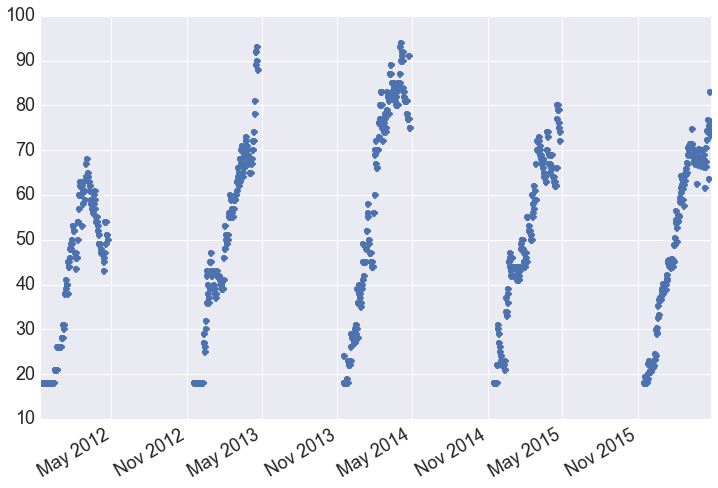

In [651]:
df.basedepth.plot(linestyle='', marker='o')

### Create a training and holdout set

In [806]:
#df_tr = pd.concat([df.ix[datetime.datetime(2011,11,1):datetime.datetime(2012,5,1)],df.ix[datetime.datetime(2013,11,1):datetime.datetime(2015,5,1)]], axis=0)
df_tr = df.ix[datetime.datetime(2011,11,1):datetime.datetime(2014,5,1)]
df_h = df.ix[datetime.datetime(2014,12,1):datetime.datetime(2015,5,1)]
df_fut = df.ix[datetime.datetime(2011,5,1):]

## Forward selection

In [807]:
lin_regr = linear_model.LinearRegression()

In [808]:
ref_column = 'skiers'
features = list(df_tr.columns.values)
features.remove('skiers')

In [809]:
X_tr = df_tr[features]
y_tr = df_tr.skiers.values
X_h = df_h[features].values

In [810]:
mar_pos = list(df_tr.index.get_indexer_for(df_tr[df_tr.month_3 == 1].index))
apr_pos = list(df_tr.index.get_indexer_for(df_tr[df_tr.month_4 == 1].index))
X_tr_mar = df_tr.iloc[mar_pos][features]
X_tr_apr = df_tr.iloc[apr_pos][features]
y_tr_mar = df_tr.iloc[mar_pos].skiers
y_tr_apr = df_tr.iloc[apr_pos].skiers

In [811]:
leave_out = ['day_5', 'midweek', 'day_0', 'xmas', 'day_4', 'day_0', 'spring_break']
features_input = [f for f in features if f not in leave_out]

In [ ]:
fs_features, RMSE = forward_selection_lodo(lin_regr, X_tr, y_tr, 50, features_input, y_tr_mar, y_tr_apr, mar_pos, apr_pos)

In [ ]:
plot_error_vs_features(RMSE, 'none', 'none')

In [ ]:
i = 6
while i < 50:
    num_good_feat = i
    df_reg = pd.concat([df_tr.skiers, df_tr[fs_features[0:i]]], axis=1)
    X_tr = df_tr[fs_features[0:i]]
    y_tr = df_tr.skiers.values
    mdl = lin_regr.fit(X_tr, y_tr) 
    cv_pred = cross_val_predict(lin_regr, X_tr, y_tr, cv = 10)
    df_reg['pred'] = cv_pred
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2011-11-1 00:00:00', '2012-05-1 00:00:00'])
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2012-11-1 00:00:00', '2013-05-1 00:00:00'])
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2013-11-1 00:00:00', '2014-05-1 00:00:00'])
    plot_learning_curve(lin_regr, "Learning Curve- Number of features = " + str(i), df_tr[fs_features[:i]].values, df_tr[ref_column].values, (0,5000000), 5, np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95,0.97, 1.0]))
    i += 5

In [722]:
fs_features = ['day_5', 'midweek', 'day_0', 'xmas', 'spring_break', 'tot_snow', 'ln_month_4_open_lifts', 'open_lifts_sq', 'pres_day_sun_open_lifts_cu', 'mlk_sun_open_lifts_cu', 'days_since_start_open_lifts_sq', 'ln_5day_snow_tot_open_lifts', 'pres_day_sat', 'open_trails_midweek', 'days_since_start_xmas_sqrt', 'thanksgiv_open_lifts_sqrt', 'thanksgiv_open_lifts', 'month_4_midweek', 'midweek_open_lifts_sq', 'month_3_midweek', 'pres_day_mon_open_lifts_cu', 'xmas_mon', 'open_trails_sat_cu', 'ln_before_xmas_sun_open_lifts', '6day_snow_tot_open_lifts_sqrt', '6day_snow_tot_sqrt', 'thanksgiv_midweek', 'days_since_start_fri_cu', 'open_percent', 'mlk_sat_sat', 'before_xmas_mon', 'ln_5day_snow_tot', 'ln_week_snow_tot_mon', '3day_snow_tot_mon_cu', 'week_snow_tot_mon_sq', '3day_snow_tot_cu', 'week_snow_tot_fri_cu', 'before_xmas_weekday', 'xmas_sun_open_lifts_cu', 'xmas_sun_open_lifts_sq', '4day_snow_tot_xmas_cu', '2day_snow_tot_sq', 'new_24_cu', 'ln_new_24_xmas', '2day_snow_tot_fri_cu', 'month_2_sat', 'open_percent_mon_cu', 'open_trails_mon_sq', '2day_snow_tot_open_lifts', 'pres_day_mon']

In [723]:
num_feat = 35
best_features = fs_features[0:num_feat]

In [724]:
df_hold = pd.concat([df_h.skiers, df_h[best_features]], axis=1)
X_tr = df_tr[best_features]
y_tr = df_tr.skiers.values
X_h = df_h[best_features]
y_h = df_h.skiers.values
mdl = lin_regr.fit(X_tr, y_tr) 
pred_h = mdl.predict(X_h) 
df_hold['pred'] = pred_h
RMSE = round(np.sqrt(mean_squared_error(y_h, pred_h)), 1)
print 'Holdout RMSE:', RMSE

Holdout RMSE: 1826.3


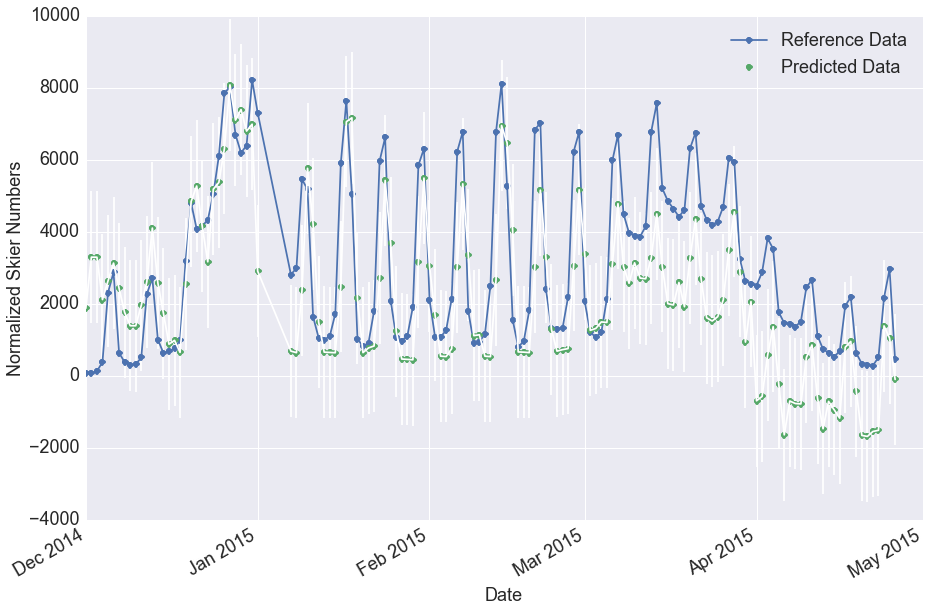

In [729]:
plot_fitted_and_ref_vs_time(df_hold, ref_column, ['2014-12-1 00:00:00', '2015-05-1 00:00:00'], RMSE)

In [ ]:
def get_holdout_RMSE(model, feat, df_tr, df_H):
    df_hold = pd.concat([df_h.skiers, df_h[feat]], axis=1)
    X_tr = df_tr[feat]
    y_tr = df_tr.skiers.values
    X_h = df_h[feat]
    y_h = df_h.skiers.values
    mdl = model.fit(X_tr, y_tr) 
    pred_h = mdl.predict(X_h) 
    df_hold['pred'] = pred_h
    RMSE = round(np.sqrt(mean_squared_error(y_h, pred_h)), 1)
    print 'Holdout RMSE:', RMSE

### Lasso

In [717]:
features = list(df.columns.values)
features.remove('skiers')

In [719]:
X_tr = df_tr[features]
y_tr = df_tr.skiers.values
X_h = df_h[features]
y_h = df_h.skiers.values

In [721]:
best_lambda, lambda_lasso, coefs, mean_score_lambda = find_best_lambda(linear_model.Lasso, features, X_tr, y_tr, 1e-10, 1000000, 1.5)

Best Lambda: 705039.282284


In [ ]:
plot_lambda(lambda_lasso, coefs, mean_score_lambda)

In [805]:
cv_pred_lasso[mar_pos]

array([  6.09190048e+02,   1.85602408e+03,   5.09214447e+03,
         3.53657626e+03,   7.03981685e+02,   3.85066660e+02,
         2.75754078e+02,   2.34247775e+02,   1.86987718e+03,
         4.04652051e+03,   2.87907970e+03,   4.23985888e+02,
         9.32485710e+01,   3.07630782e+01,   1.46953247e+02,
         1.43277384e+03,   2.81809905e+03,   1.83640436e+03,
         5.61879411e+00,  -2.02702397e+02,  -2.52440673e+02,
        -3.31786356e+02,   1.16877312e+03,   1.71004430e+03,
         5.01538891e+02,  -6.39162537e+02,  -8.24967047e+02,
        -5.60704899e+02,  -7.26830428e+02,   4.20989613e+02,
         8.09045091e+02,   2.91031253e+03,   6.73327060e+03,
         5.86213373e+03,   1.80981496e+03,   1.57148590e+03,
         1.51342372e+03,   1.53155957e+03,   3.31275612e+03,
         6.20704515e+03,   2.80510081e+03,   2.13062095e+03,
         3.07586786e+03,   2.22954068e+03,   2.21134950e+03,
         2.94624082e+03,   5.56834864e+03,   4.02749571e+03,
         1.73337651e+03,

In [803]:
clf = linear_model.Lasso(alpha=best_lambda)
lasso = clf.fit(X_tr, y_tr)
cv_pred_lasso = cross_val_predict(lasso, X_tr, y_tr, cv = 10)
print cv_pred_lasso

[  8.43841859e+02   8.43839838e+02   8.48120381e+02   8.48103284e+02
   8.48074816e+02   8.72206609e+02   8.65410549e+02   8.43365363e+02
   8.43428802e+02   8.47686293e+02   8.47517326e+02   8.47314669e+02
   8.71820133e+02   8.64417298e+02   8.40768575e+02   8.41406287e+02
   8.45744548e+02   8.45275424e+02   8.44751169e+02   8.70742600e+02
   8.61844279e+02   8.34238119e+02   8.36469107e+02   8.64055117e+02
   8.68498999e+02   8.69438301e+02   9.03447317e+02   9.32896768e+02
   8.77477663e+02   8.59681412e+02   9.02739372e+02   9.02797314e+02
   9.10656758e+02   1.10365208e+03   1.16929171e+03   1.15938435e+03
   1.13152314e+03   1.08766900e+03   1.09755431e+03   1.12251590e+03
   1.27890526e+03   1.37586136e+03   3.89723534e+03   4.04423795e+03
   4.31608745e+03   4.51381372e+03   4.73658104e+03   5.18764986e+03
   7.22052405e+03   7.53632480e+03   1.38002412e+03   1.40763620e+03
   1.42259838e+03   1.51592007e+03   1.81259029e+03   1.95732628e+03
   1.78001881e+03   1.65051993e+03

In [ ]:
df_tr['lasso_pred'] = cv_pred_lasso

In [ ]:
%matplotlib inline
plot_lasso_and_ref_vs_time(df_tr, ref_column, ['2011-11-1 00:00:00', '2012-05-1 00:00:00'])
plot_lasso_and_ref_vs_time(df_tr, ref_column, ['2012-11-1 00:00:00', '2013-05-1 00:00:00'])
plot_lasso_and_ref_vs_time(df_tr, ref_column, ['2013-11-1 00:00:00', '2014-05-1 00:00:00'])

In [687]:
X_h = df_h[best_features]

## Random Forest

In [ ]:
rfr = RandomForestRegressor(random_state=0, n_estimators=100)


### Export Model

In [ ]:
#saving pickle file as .p is best
pickle_out = open('lin_regr.pkl', 'wb')
pickle.dump(mdl, pickle_out)
pickle_out.close()

# Export Data

In [ ]:
df_out = df_all.drop(['model_pred','skiers'], axis=1)

In [ ]:
df_out.to_csv('../webpage_ski/df_all_features.csv')